In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


%matplotlib notebook
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm.auto import tqdm

from utils import *

In [3]:
import psutil
psutil.cpu_count()

8

In [4]:
NTHREADS = psutil.cpu_count()-1
SEED = 42
BUCKET_WINDOWS2 = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500), (500, 600)]

DATA_PATH = '../input/optiver-realized-volatility-prediction'
BOOK_TRAIN_PATH = '../input/optiver-realized-volatility-prediction/book_train.parquet'
TRADE_TRAIN_PATH = '../input/optiver-realized-volatility-prediction/trade_train.parquet'
BOOK_TEST_PATH = '../input/optiver-realized-volatility-prediction/book_test.parquet'
TRADE_TEST_PATH = '../input/optiver-realized-volatility-prediction/trade_test.parquet'
CHECKPOINT = 'model_checkpoint/model_01'

book_skip_columns = trade_skip_columns = ['time_id', 'row_id', 'target']

In [5]:
import pickle
data_input = open('../LSTMtemp/np_train.pkl','rb')
np_train = pickle.load(data_input)
data_input.close()

data_input = open('../LSTMtemp/targets.pkl','rb')
targets = pickle.load(data_input)
data_input.close()

In [6]:
np_train.shape

(428932, 36, 29)

In [7]:
idx = np.arange(np_train.shape[0])
train_idx, valid_idx = train_test_split(idx, shuffle=False, test_size=0.1, random_state=2021)

In [8]:
# Loss function
def rmspe(y_true, y_pred):
    return torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))

In [9]:
class MyDataset2():
    def __init__(self, ds, targets, batch_size):
        self.ds = ds
        self.y = targets[:,np.newaxis]
        self.batch_size = batch_size
        self.indexes = np.arange(self.ds.shape[0])
        self.index = 0
        
    def __getitem__(self, i):
        batch_index = self.indexes[i * self.batch_size : (i + 1) * self.batch_size]
        X = self.ds[batch_index]
        Y = self.y[batch_index]
        return X,Y
    
    def __call__(self, i):
        batch_index = self.indexes[i * self.batch_size : (i + 1) * self.batch_size]
        X = self.ds[batch_index]
        Y = self.y[batch_index]
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)
        return X,Y
    
    def __len__(self):
        return int(np.ceil(self.ds.shape[0] / self.batch_size))
    
    def next_item(self):
        if self.index >= self.__len__():
            self.index = 0
        X, Y = self.__getitem__(self.index)
        self.index += 1
        return X, Y

In [10]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionBlock(dim_val, dim_attn , n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
    
    def forward(self, x):
        a = self.attn(x)
        x = self.norm1(x + a)
        
        a = self.fc1(F.elu(self.fc2(x)))
        x = self.norm2(x + a)
        
        return x

class DecoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.attn2 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
        self.norm3 = nn.LayerNorm(dim_val)
        
    def forward(self, x, enc):
        a = self.attn1(x)
        x = self.norm1(a + x)
        
        a = self.attn2(x, kv = enc)
        x = self.norm2(a + x)
        
        a = self.fc1(F.elu(self.fc2(x)))
        
        x = self.norm3(x + a)
        return x

In [11]:
class Transformer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, dec_seq_len,
                 out_seq_len = 1, n_decoder_layers = 1, n_encoder_layers = 1,
                 n_heads = 1):
        super(Transformer, self).__init__()
        self.dec_seq_len = dec_seq_len
        
        #Initiate encoder and Decoder layers
        self.encs = nn.ModuleList()
        for i in range(n_encoder_layers):
            self.encs.append(EncoderLayer(dim_val, dim_attn, n_heads))
        
        self.decs = nn.ModuleList()
        for i in range(n_decoder_layers):
            self.decs.append(DecoderLayer(dim_val, dim_attn, n_heads))
        
        self.pos = PositionalEncoding(dim_val)
        
        #Dense layers for managing network inputs and outputs
        self.enc_input_fc = nn.Linear(input_size, dim_val)
        self.dec_input_fc = nn.Linear(input_size, dim_val)
        self.out_fc = nn.Linear(dec_seq_len * dim_val, out_seq_len)
    
    def forward(self, x):
        #encoder
        e = self.encs[0](self.pos(self.enc_input_fc(x)))
#         print('e1',e.shape)
        for enc in self.encs[1:]:
            e = enc(e)
        
#         print('e2',e.shape)
        #decoder
        d = self.decs[0](self.dec_input_fc(x[:,-self.dec_seq_len:]), e)
#         print('d1',d.shape)
        for dec in self.decs[1:]:
            d = dec(d, e)
            
        #output
#         print('d2',d.shape)
        x = self.out_fc(d.flatten(start_dim=1))
#         with torch.no_grad():
#             print('x',x.unique())
        
        return x

In [12]:
class Myloss(nn.Module):
    def __init__(self):
        super(Myloss, self).__init__()
    
    def forward(self, y_true, y_pred):
        x = torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))
        return x

In [13]:
assert torch.cuda.is_available()
device = 'cuda'

In [18]:
# Hyperparams
enc_seq_len = 6
dec_seq_len =2

dim_val = 10 # PositionalEncoding需要特征数为偶数
dim_attn = 10

lr = 0.003

n_heads = 2

n_encoder_layers = 2
n_decoder_layers = 2

Batch_size = 256

model = Transformer(dim_val=dim_val, dim_attn=dim_attn, input_size=29,
                   dec_seq_len=dec_seq_len,
                   n_encoder_layers=n_encoder_layers,n_decoder_layers=n_decoder_layers,
                   n_heads=n_heads)
model.to(device)

Transformer(
  (encs): ModuleList(
    (0): EncoderLayer(
      (attn): MultiHeadAttentionBlock(
        (heads): ModuleList(
          (0): AttentionBlock(
            (value): Value(
              (fc1): Linear(in_features=10, out_features=10, bias=False)
            )
            (key): Key(
              (fc1): Linear(in_features=10, out_features=10, bias=False)
            )
            (query): Query(
              (fc1): Linear(in_features=10, out_features=10, bias=False)
            )
          )
          (1): AttentionBlock(
            (value): Value(
              (fc1): Linear(in_features=10, out_features=10, bias=False)
            )
            (key): Key(
              (fc1): Linear(in_features=10, out_features=10, bias=False)
            )
            (query): Query(
              (fc1): Linear(in_features=10, out_features=10, bias=False)
            )
          )
        )
        (fc): Linear(in_features=20, out_features=10, bias=False)
      )
      (fc1): Linear(in

In [19]:
criterion = Myloss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,factor = 0.2)

In [20]:
mytrainloader = MyDataset2(np_train[train_idx, :, :], targets[train_idx], Batch_size)
mytestloader = MyDataset2(np_train[valid_idx, :, :], targets[valid_idx], Batch_size)

In [21]:
train_loss = []
val_loss = []
best_loss = float('+inf')
if hasattr(torch.cuda, 'empty_cache'):
    torch.cuda.empty_cache()

epochs = 100
counter = 0

for epoch in tqdm(range(epochs)):
    model.train()
    avg_loss = []
    for i in range(len(mytrainloader)):
        x, y = mytrainloader(i)
        x = x.to(device)
        x = x.float()
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
#         print('output:',output.shape)
#         print('targets:',y.shape)
        loss = criterion(y,output)
        avg_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    avg_loss = np.array(avg_loss).mean()
    train_loss.append(avg_loss)
    scheduler.step(avg_loss)
    
    model.eval()
    val_aloss = []
    with torch.no_grad():
        for i in range(len(mytestloader)):
            x,y = mytestloader(i)
            x = x.float()
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss = criterion(y, output)
            val_aloss.append(loss.item())
        val_aloss = np.array(val_aloss).mean()
        val_loss.append(val_aloss)
    
    if val_aloss <best_loss:
        best_loss = val_aloss
        best_epoch = epoch
        torch.save(model.state_dict(), 'MyTrans_model.pt')
        counter = 0
    counter += 1
    print('Epoch:  {}   |Train_Loss: {:.6f} |Val_Loss: {:.6f}'.format(epoch + 1,avg_loss,val_aloss))
    if counter >= 9:
        print('连续{}个epoch没有下降了'.format(counter))

Epoch:  1   |Train_Loss: 3.030877 |Val_Loss: 1.071396
Epoch:  2   |Train_Loss: 0.722358 |Val_Loss: 0.271753
Epoch:  3   |Train_Loss: 0.636995 |Val_Loss: 0.544035
Epoch:  4   |Train_Loss: 0.618181 |Val_Loss: 0.448745
Epoch:  5   |Train_Loss: 0.566088 |Val_Loss: 0.370627
Epoch:  6   |Train_Loss: 0.464785 |Val_Loss: 0.366890
Epoch:  7   |Train_Loss: 0.433433 |Val_Loss: 0.633692
Epoch:  8   |Train_Loss: 0.454770 |Val_Loss: 0.305045
Epoch:  9   |Train_Loss: 0.459507 |Val_Loss: 0.414711
Epoch:  10   |Train_Loss: 0.499645 |Val_Loss: 0.297113
连续9个epoch没有下降了
Epoch:  11   |Train_Loss: 0.344397 |Val_Loss: 0.461124
连续10个epoch没有下降了
Epoch:  12   |Train_Loss: 0.386504 |Val_Loss: 0.350534
连续11个epoch没有下降了
Epoch:  13   |Train_Loss: 0.351237 |Val_Loss: 0.318527
连续12个epoch没有下降了
Epoch:  14   |Train_Loss: 0.296684 |Val_Loss: 0.258902
Epoch:  15   |Train_Loss: 0.316045 |Val_Loss: 0.261155
Epoch:  16   |Train_Loss: 0.302846 |Val_Loss: 0.301256
Epoch:  17   |Train_Loss: 0.276966 |Val_Loss: 0.275658
Epoch:  18 

<IPython.core.display.Javascript object>


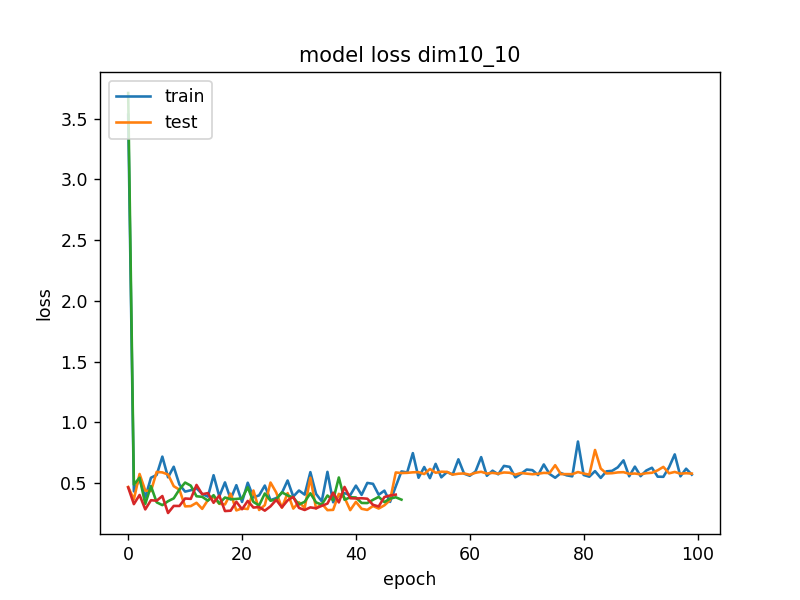

Min val_loss is: 0.2744970175304583 at 19 epoch


In [103]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','test'], loc = 'upper left')
plt.show()
print('Min val_loss is:',best_loss,'at',best_epoch,'epoch')

<IPython.core.display.Javascript object>


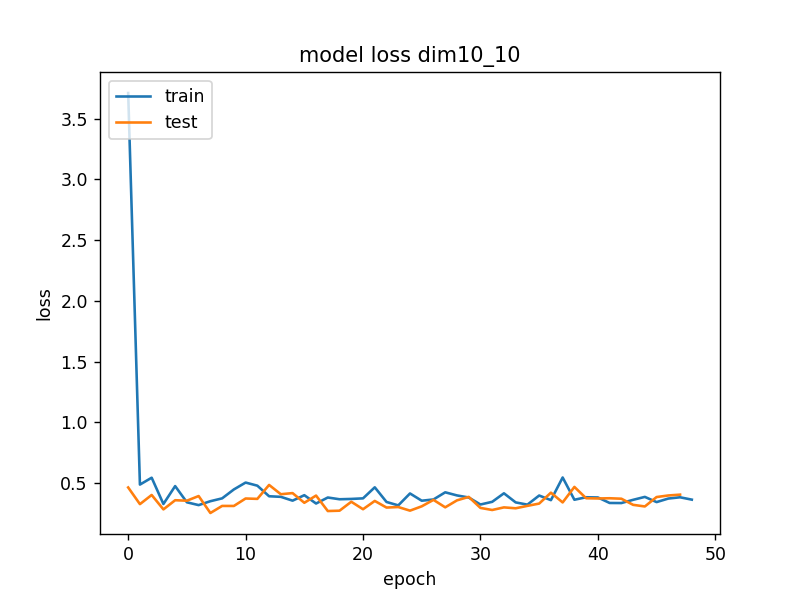

Min val_loss is: 0.2532302781584717 at 7 epoch


In [110]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss dim10_10')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','test'], loc = 'upper left')
plt.show()
print('Min val_loss is:',best_loss,'at',best_epoch,'epoch')

<IPython.core.display.Javascript object>


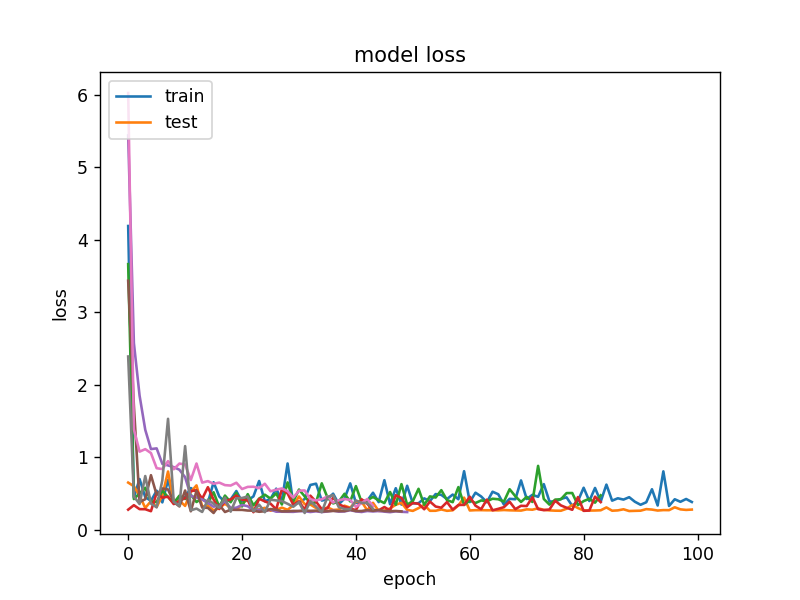

Min val_loss is: 0.2585003591541733 at 88 epoch
The Hyperparameter:
    enc_seq_len = 8
    dec_seq_len =5
    dim_val = 20
    dim_attn = 10
    lr = 0.006
    n_heads = 2
    n_encoder_layers = 3
    n_decoder_layers = 2
      


In [124]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','test'], loc = 'upper left')
plt.show()
print('Min val_loss is:',best_loss,'at',best_epoch,'epoch')
print("""The Hyperparameter:
    enc_seq_len = {}
    dec_seq_len ={}
    dim_val = {}
    dim_attn = {}
    lr = {}
    n_heads = {}
    n_encoder_layers = {}
    n_decoder_layers = {}
      """.format(enc_seq_len,dec_seq_len, dim_val, dim_attn, lr,
                n_heads, n_encoder_layers, n_decoder_layers))

In [143]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','test'], loc = 'upper left')
plt.show()
print('Min val_loss is:',best_loss,'at',best_epoch,'epoch')
print("""The Hyperparameter:
    enc_seq_len = {}
    dec_seq_len ={}
    dim_val = {}
    dim_attn = {}
    lr = {}
    n_heads = {}
    n_encoder_layers = {}
    n_decoder_layers = {}
      """.format(enc_seq_len,dec_seq_len, dim_val, dim_attn, lr,
                n_heads, n_encoder_layers, n_decoder_layers))

Min val_loss is: 0.2316423992493323 at 15 epoch
The Hyperparameter:
    enc_seq_len = 8
    dec_seq_len =5
    dim_val = 16
    dim_attn = 10
    lr = 0.001
    n_heads = 2
    n_encoder_layers = 3
    n_decoder_layers = 2
      


In [154]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','test'], loc = 'upper left')
plt.show()
print('Min val_loss is:',best_loss,'at',best_epoch,'epoch')
print("""The Hyperparameter:
    enc_seq_len = {}
    dec_seq_len ={}
    dim_val = {}
    dim_attn = {}
    lr = {}
    n_heads = {}
    n_encoder_layers = {}
    n_decoder_layers = {}
      """.format(enc_seq_len,dec_seq_len, dim_val, dim_attn, lr,
                n_heads, n_encoder_layers, n_decoder_layers))

Min val_loss is: 0.2313295514101074 at 31 epoch
The Hyperparameter:
    enc_seq_len = 8
    dec_seq_len =4
    dim_val = 10
    dim_attn = 10
    lr = 0.001
    n_heads = 1
    n_encoder_layers = 3
    n_decoder_layers = 2
      


In [22]:
def write_log(today,params,train_loss,val_loss):
    
    plt.figure()
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig('log/Model_{}_{}.png'.format('Infomer',today))
    
    f = open('log/Model_{}_{}.txt'.format('Infomer',today),'a+')
    enc_seq_len,dec_seq_len, dim_val, dim_attn, lr, n_heads, n_encoder_layers, n_decoder_layers = params
    f.write('Min val_loss is:{} at {} epoch \n'.format(best_loss, best_epoch))
    f.write("""The Hyperparameter:
    enc_seq_len = {}
    dec_seq_len ={}
    dim_val = {}
    dim_attn = {}
    lr = {}
    n_heads = {}
    n_encoder_layers = {}
    n_decoder_layers = {}
      """.format(enc_seq_len,dec_seq_len, dim_val, dim_attn, lr,
                n_heads, n_encoder_layers, n_decoder_layers))
    f.close()

<IPython.core.display.Javascript object>


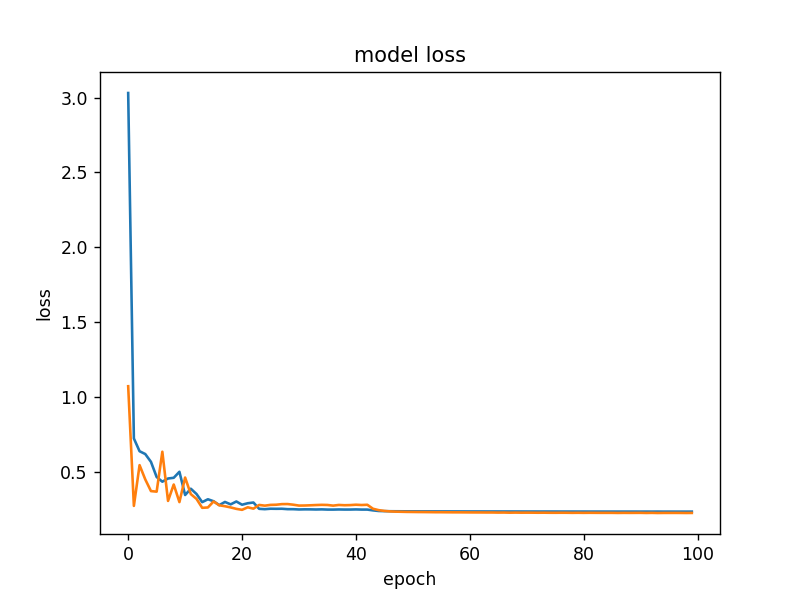

In [25]:
import time
today = time.strftime("%m-%d-%H-%M", time.localtime())
params = [enc_seq_len,dec_seq_len, dim_val, dim_attn, lr, n_heads, n_encoder_layers, n_decoder_layers]
write_log(today,params,train_loss,val_loss)